In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_frame = pd.read_csv('../ANN_part2/mnist_train.csv', delimiter=',')
data = data_frame.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(60000,)
(60000, 784)


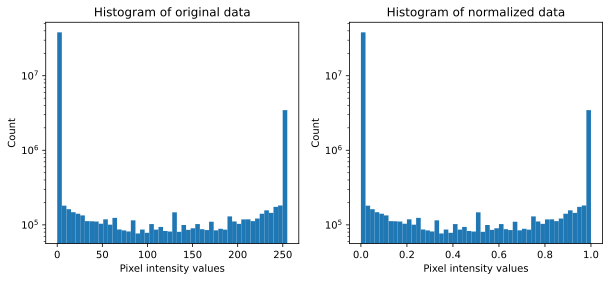

In [3]:
# normalize data to a range of [0, 1]
data_norm = data / np.max(data)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

In [4]:
data_tensor = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output = nn.Linear(32, 10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)
        
    model = MnistNet()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [6]:
tmp_model = create_model()[0]
print(tmp_model)

print("\n\nWeights for layer fc1:")
print(tmp_model.fc1.weight.data)

MnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[ 0.0085, -0.0500, -0.0595,  ...,  0.0775,  0.1224, -0.0143],
        [-0.0244,  0.1022,  0.1003,  ..., -0.0580, -0.0117,  0.0398],
        [-0.0439,  0.0120, -0.1125,  ...,  0.1114, -0.0046,  0.0111],
        ...,
        [ 0.0005,  0.0921,  0.0271,  ...,  0.0360,  0.1102,  0.1163],
        [-0.0662,  0.1008,  0.0168,  ...,  0.1082,  0.0787, -0.0963],
        [ 0.1073, -0.0282,  0.0185,  ..., -0.0048, -0.0495,  0.0993]])


In [7]:
num_of_epochs = 10
def train_model(model, loss_func, optimizer):
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X,y in  train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        model.eval()
        
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X)
        
        test_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        
    return train_acc, test_acc, losses, model

In [8]:
model, loss_func, optimizer = create_model()
train_acc, test_acc, losses, model = train_model(model, loss_func, optimizer)

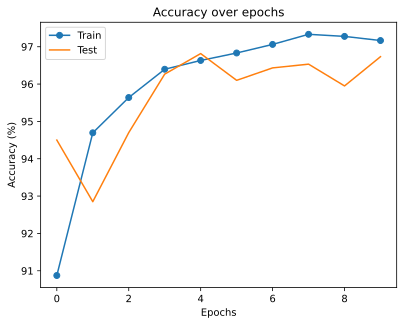

In [9]:
plt.plot(range(num_of_epochs), train_acc, 'o-', range(num_of_epochs), test_acc)
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [10]:
model_zero, loss_func, optimizer = create_model()

model_zero.fc1.weight.data = torch.zeros_like(model_zero.fc1.weight)

model_zero.fc1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

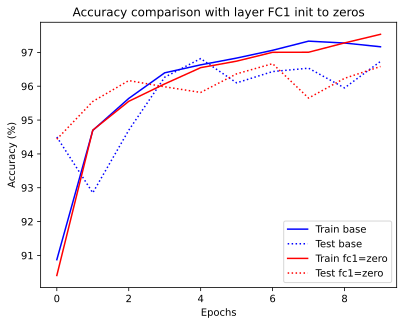

In [11]:
train_acc_zero, test_acc_zero, losses_zero, model_zero = train_model(model_zero, loss_func, optimizer)

plt.plot(range(num_of_epochs), train_acc, 'b-', range(num_of_epochs), test_acc, 'b:')
plt.plot(range(num_of_epochs), train_acc_zero, 'r-', range(num_of_epochs), test_acc_zero, 'r:')
plt.legend(['Train base','Test base', 'Train fc1=zero', 'Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

tensor([[ 0.6672, -0.2536, -0.6027,  ...,  0.6401, -0.5206,  0.0037],
        [-1.5822, -0.0352, -1.5339,  ...,  0.8143, -1.3082, -0.7855],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.6210, -1.0949, -1.1483,  ..., -0.5460,  0.8436, -1.1467],
        [ 0.9570, -0.2096,  1.1003,  ..., -0.8902, -0.5695,  0.0037],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


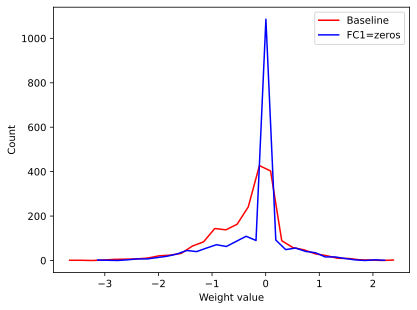

In [12]:
print(model_zero.fc1.weight.data)

y,x = np.histogram(model.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, 'r', label='Baseline')

y,x = np.histogram(model_zero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, 'b', label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

In [13]:
model_all_zero, loss_func, optimizer = create_model()
for p in model_all_zero.named_parameters():
    p[1].data = torch.zeros_like(p[1].data)

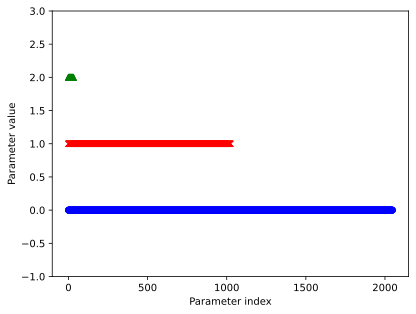

In [14]:
plt.plot(0+model_all_zero.fc1.weight.data.flatten(), 'bo')
plt.plot(1+model_all_zero.fc2.weight.data.flatten(), 'rx')
plt.plot(2+model_all_zero.fc1.bias.data.flatten(), 'g^')
plt.xlabel('Parameter index')
plt.ylim([-1, 3])
plt.ylabel('Parameter value')
plt.show()

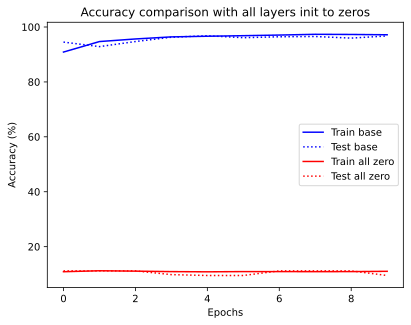

In [15]:
train_acc_all_zero, test_acc_all_zero, losses_all_zero, model_all_zero = train_model(model_all_zero, loss_func, optimizer)

plt.plot(range(num_of_epochs), train_acc, 'b-', range(num_of_epochs), test_acc, 'b:')
plt.plot(range(num_of_epochs), train_acc_all_zero, 'r-', range(num_of_epochs), test_acc_all_zero, 'r:')
plt.legend(['Train base','Test base', 'Train all zero', 'Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

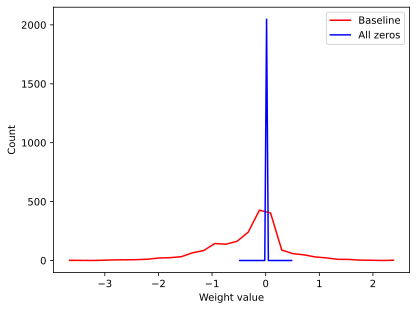

In [16]:

y,x = np.histogram(model.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, 'r', label='Baseline')

y,x = np.histogram(model_all_zero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2, y, 'b', label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

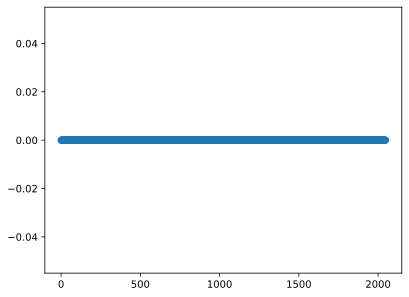

In [17]:
plt.plot(model_all_zero.fc1.weight.data.flatten(), 'o')

In [18]:
model_all_one, loss_func, optimizer = create_model()
for p in model_all_one.named_parameters():
    p[1].data = torch.zeros_like(p[1].data) + 1

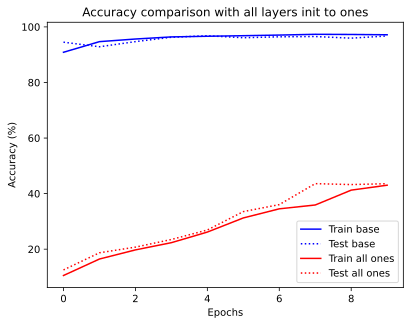

In [19]:
train_acc_all_one, test_acc_all_one, losses_all_one, model_all_one = train_model(model_all_one, loss_func, optimizer)

plt.plot(range(num_of_epochs), train_acc, 'b-', range(num_of_epochs), test_acc, 'b:')
plt.plot(range(num_of_epochs), train_acc_all_one, 'r-', range(num_of_epochs), test_acc_all_one, 'r:')
plt.legend(['Train base','Test base', 'Train all ones', 'Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [26]:
model_ones_zeros, loss_func, optimizer = create_model()
for idx, p in enumerate(model_ones_zeros.named_parameters()):
    if idx % 2 == 0: 
        p[1].data = torch.zeros_like(p[1].data) + 1
    else:
        p[1].data = torch.zeros_like(p[1].data)

for p in model_ones_zeros.named_parameters():
    print(p)


('input.weight', Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True))
('input.bias', Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True))
('fc1.bias', Parameter conta

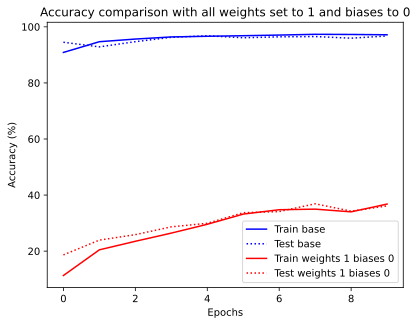

In [27]:
train_acc_ones_zeros, test_acc_ones_zeros, losses_ones_zeros, model_ones_zeros = train_model(model_ones_zeros, loss_func, optimizer)

plt.plot(range(num_of_epochs), train_acc, 'b-', range(num_of_epochs), test_acc, 'b:')
plt.plot(range(num_of_epochs), train_acc_ones_zeros, 'r-', range(num_of_epochs), test_acc_ones_zeros, 'r:')
plt.legend(['Train base','Test base', 'Train weights 1 biases 0', 'Test weights 1 biases 0'])
plt.title('Accuracy comparison with all weights set to 1 and biases to 0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [32]:
model_weights_zeros, loss_func, optimizer = create_model()
for idx, p in enumerate(model_weights_zeros.named_parameters()):
    if idx % 2 == 0: 
        p[1].data = torch.zeros_like(p[1].data)
        
for p in model_weights_zeros.named_parameters():
    print(p)

train_acc_weights_zeros, test_acc_weights_zeros, losses_weights_zeros, model_weights_zeros = train_model(model_weights_zeros, loss_func, optimizer)


model_biases_zeros, loss_func, optimizer = create_model()
for idx, p in enumerate(model_biases_zeros.named_parameters()):
    if idx % 2 == 1: 
        p[1].data = torch.zeros_like(p[1].data)

for p in model_biases_zeros.named_parameters():
    print(p)
train_acc_biases_zeros, test_acc_biases_zeros, losses_biases_zeros, model_biases_zeros = train_model(model_biases_zeros, loss_func, optimizer)
       

('input.weight', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True))
('input.bias', Parameter containing:
tensor([-1.2271e-02,  2.2137e-02, -2.9866e-02,  9.6544e-03, -3.3416e-02,
         2.6724e-02, -2.0346e-02,  2.0210e-02,  3.1504e-02,  5.8641e-03,
         1.9500e-02, -1.0821e-02,  8.3583e-05,  8.8753e-03,  3.4061e-02,
         1.3274e-02,  2.3065e-02, -1.2710e-02, -1.4857e-02,  2.3984e-02,
        -1.0066e-02, -1.5220e-02, -7.9969e-03, -1.5147e-02,  1.5417e-02,
        -2.0949e-02,  3.2286e-02, -2.2609e-02,  8.6574e-03,  8.4729e-03,
        -9.6180e-04, -1.3290e-02,  2.5259e-02, -2.4013e-02,  2.9149e-03,
         8.9803e-04,  1.1585e-03, -1.2469e-02,  1.8568e-02, -1.0490e-02,
         8.6281e-03, -1.1761e-02, -9.6623e-03, -9.5082e-03, -2.55

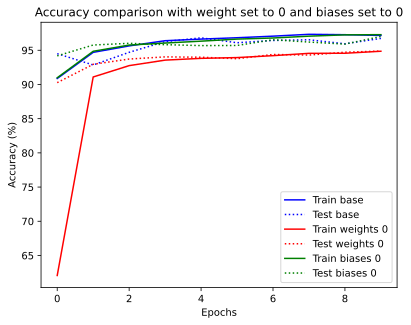

In [30]:
plt.plot(range(num_of_epochs), train_acc, 'b-', range(num_of_epochs), test_acc, 'b:')
plt.plot(range(num_of_epochs), train_acc_weights_zeros, 'r-', range(num_of_epochs), test_acc_weights_zeros, 'r:')
plt.plot(range(num_of_epochs), train_acc_biases_zeros, 'g-', range(num_of_epochs), test_acc_biases_zeros, 'g:')
plt.legend(['Train base','Test base', 'Train weights 0', 'Test weights 0', 'Train biases 0', 'Test biases 0'])
plt.title('Accuracy comparison with weight set to 0 and biases set to 0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()